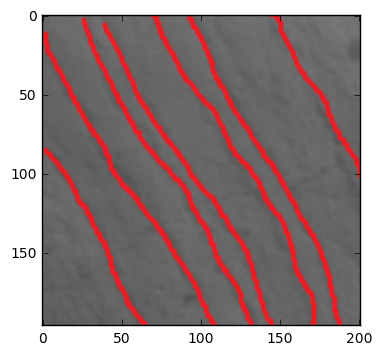

In [1]:
#Importar imágenes
from skimage import io
%matplotlib inline
import matplotlib.pyplot as plt

pathMasc="C:\\Users\\Andres\\Documents\\GitHub\\Perikymata2017\\prototypes\\imagenesParaEnviar\\1muyvisiblesbastantefiable\\9stmarcado.bmp"
pathImg="C:\\Users\\Andres\\Documents\\GitHub\\Perikymata2017\\prototypes\\imagenesParaEnviar\\1muyvisiblesbastantefiable\\9storiginal.bmp"
pathCSV="C:\\Users\\Andres\\Documents\\GitHub\\Perikymata2017\\prototypes\\imagenesParaEnviar\\1muyvisiblesbastantefiable\\9stlinea.csv"

img = io.imread(pathImg)
msc = io.imread(pathMasc)
plt.imshow(msc)

In [2]:
import numpy as np

#Función para binarizar máscara marcando como blancos los rojos y negros el resto de colores.
#Threshold es el umbral para el color rojo, debería estar más o menos entre 180 y 255. 
#No hay que preocuparse en los valores del array R B G del azul y verde porque suponemos 
#que la máscara está en blanco y negro con las perikymata en rojo.
def binarizeRed(img,threshold):
    binarized = np.copy(img)
    for i in range(len(img)):
        for j in range(len(img[0])):
            if img[i][j][0] > threshold:
                binarized[i][j] = [255, 255, 255]
            else: 
                binarized[i][j] = [0, 0, 0]
    return binarized

In [3]:
from skimage.color import rgb2lab,gray2rgb

"Función de Ismael"
def distancia_al_rojo(img, pixel):
        """
        Metodo para:
        Pasamos la imagen al espacio de color RGB y nos quedamos con el canal rojo
        Pasamos la imagen al espacio de color HSV
        Normalizamos la imagen del espacio de color HSV para utilizar que distancia 
        al rojo tenemos y poder hacer el theshold.
        
        @param img: imagen original leida anteriormente.
        @return: distance_red: distancia de cada pixel al rojo para luego hacer el threshold.
        
        """ 
        r,g,b = pixel        
        g,v,b=rgb2lab([[[r/255,g/255,b/255]]])[0][0]
        
        lab=rgb2lab(img)
        distance_red=abs(lab - [g,v,b]).mean(axis=2)
        return distance_red

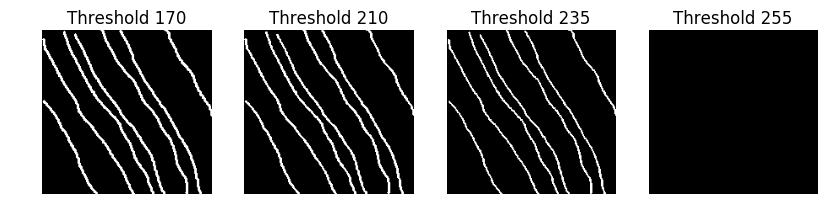

In [4]:
binMask1=binarizeRed(msc, 170)
binMask2=binarizeRed(msc, 210)
binMask3=binarizeRed(msc, 235)
binMask4=binarizeRed(msc, 255)

plt.figure()
f, axes = plt.subplots(1,4,figsize=(10, 10))
axes[0].set_title("Threshold 170")
axes[1].set_title("Threshold 210")
axes[2].set_title("Threshold 235")
axes[3].set_title("Threshold 255")

for axe in axes:
    axe.axis('off')

axes[0].imshow(binMask1);
axes[1].imshow(binMask2);
axes[2].imshow(binMask3);
axes[3].imshow(binMask4);

In [5]:
#from __future__ import print_function
#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets

#interact(binarizeRed, img=fixed(msc),x=(150,255));

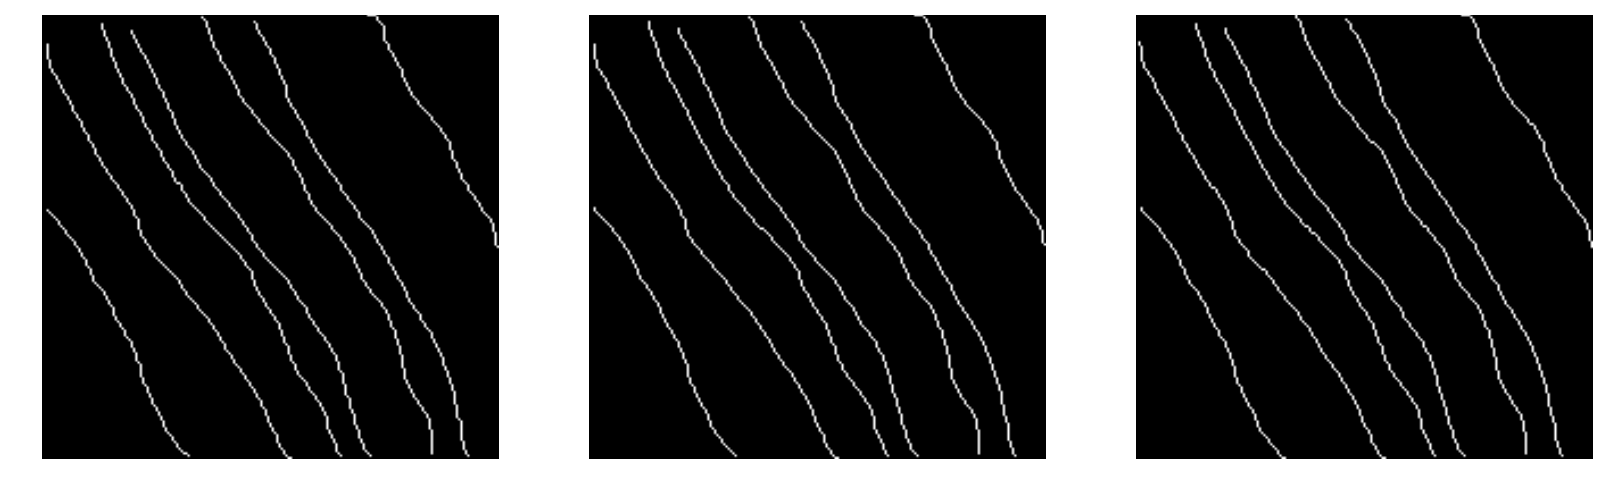

In [6]:
from skimage.morphology import skeletonize
from skimage.color import rgb2gray

# Esqueletonizar binarización de la máscara
skMask1 = skeletonize(rgb2gray(binMask1))
skMask2 = skeletonize(rgb2gray(binMask2))
skMask3 = skeletonize(rgb2gray(binMask3))

plt.figure();
f, axes = plt.subplots(1,3,figsize=(20, 20));

for axe in axes:
    axe.axis('off');

axes[0].imshow(skMask1,cmap='gray');
axes[1].imshow(skMask2,cmap='gray');
axes[2].imshow(skMask3,cmap='gray');


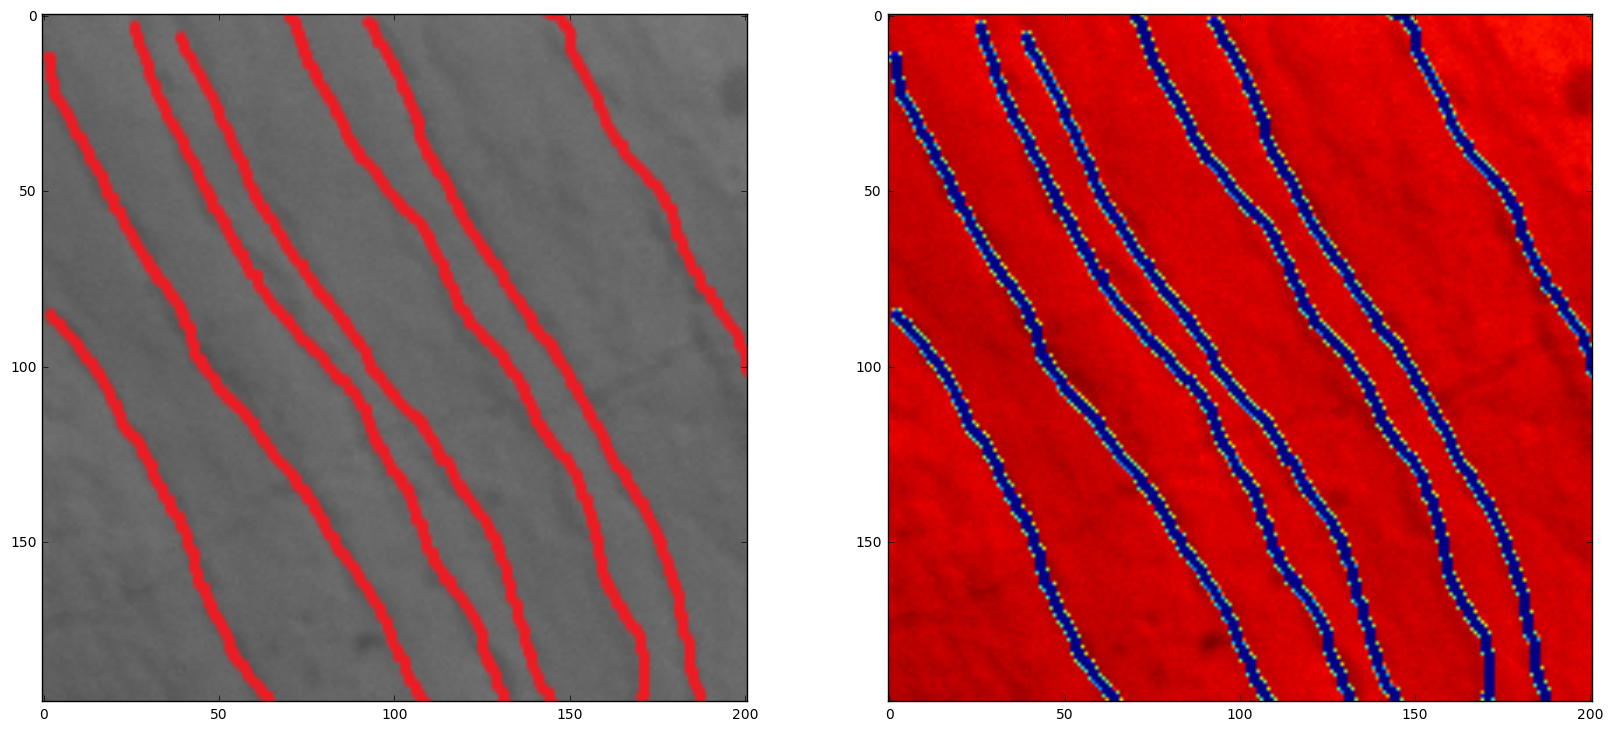

In [7]:
mskRojo=distancia_al_rojo(msc, [255, 0, 0])
plt.figure();
f, axes = plt.subplots(1,2,figsize=(20, 20));
axes[0].imshow(msc);
axes[1].imshow(mskRojo);

In [8]:
#Calcular threshold
import skimage.filters as fil

print('Li:',fil.threshold_li(mskRojo))
print('Isodata:', fil.threshold_isodata(mskRojo))
print('Otsu:', fil.threshold_otsu(mskRojo))
print('Yen:', fil.threshold_yen(mskRojo))

Li: 18.138703652
Isodata: 31.2076167593
Otsu: 31.2076167593
Yen: 51.6487538199


Threshold: 18.138703652


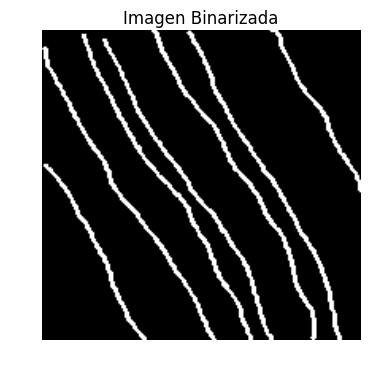

In [9]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def aplicarUmbral(img, TipoUmbral):
    threshold = None;
    if TipoUmbral == 'Li':
        threshold = fil.threshold_li(img);
    elif TipoUmbral == 'Isodata':
        threshold = fil.threshold_isodata(img);
    elif TipoUmbral == 'Otsu':
        threshold = fil.threshold_otsu(img);
    elif TipoUmbral == 'Yen':
        threshold = fil.threshold_yen(img);
    
    print('Threshold:',threshold);
    plt.figure();
    plt.axis('off');
    plt.title('Imagen Binarizada');
    plt.imshow((img<threshold), cmap='gray');
        
interact(aplicarUmbral, img=fixed(mskRojo), TipoUmbral=('Li', 'Isodata', 'Otsu', 'Yen'));

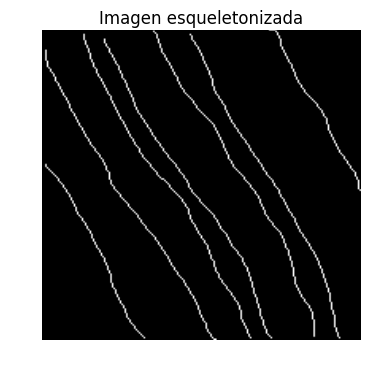

In [10]:
#Skeletonizar imagen
binMask = mskRojo<fil.threshold_li(mskRojo);
skelMask = skeletonize(binMask);
plt.figure();
plt.axis('off')
plt.title('Imagen esqueletonizada');
plt.imshow(skelMask, cmap='gray');

In [11]:
#Binarizar imagen de muestra y esqueletonizarla

def tratamientoImagen(img):
    """
    Aplica una serie de filtros a una imagen, la binariza y la esqueletoniza.
    @param img: imagen de muestra a comparar con la máscara.
    @return skeklImg: imagen esqueletonizada después del tratamiento.
    """
    #TODO

In [12]:
#Evaluar distancia
# from wiki. Pone str pero funciona con listas tb
def distance(str1, str2):
    d=dict()
    for i in range(len(str1)+1):
        d[i]=dict()
        d[i][0]=i
    for i in range(len(str2)+1):
        d[0][i] = i
    for i in range(1, len(str1)+1):
        for j in range(1, len(str2)+1):
            d[i][j] = min(d[i][j-1]+1, d[i-1][j]+1, d[i-1][j-1]+(not str1[i-1] == str2[j-1]))
    return d[len(str1)][len(str2)]

In [14]:
skelImg = tratamientoImagen(img);

distance(skelMask, skelImg)

TypeError: object of type 'NoneType' has no len()